## やりたいこと
[前回の結果](url:./20200502.ipynb)から、`scipy.signal.spectrogram`のデータ表現を変えてもAEが思い通りに動作しなかったので、モデルの設計を変えて正常動作するかを確認する。  
→中間層の活性化関数を`Relu` → `elu`,出力層を`sigmoid` → `linear`に変え、L2正規化やドロップアウトを除いた基礎的なAEで中間層の数を振りながら挙動を変えてみる。  
(中間層の重みはPCAの結果から適当に決めていて、チューニングはしていなかった)

In [1]:
# cording = UTF-8
import os,re,random,copy                    #標準ライブラリ
import scipy,librosa,sklearn,joblib,h5py    #サードパーティライブラリ
import numpy as np
import pandas as pd                         #ほとんど使わんけど
import tensorflow as tf
from tensorflow import keras                #御呪い
import matplotlib.pyplot as plt

print ("Scipy version:{0}".format(scipy.__version__))
print ("Numpy version:{0}".format(np.__version__))
print ("Pandas version:{0}".format(pd.__version__))
print ("Tensorflow version:{0}".format(tf.__version__)) #赤線は無視
print ("tf.keras version:{0}".format(tf.keras.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("joblib version:{0}".format(joblib.__version__))
print ("h5py version:{0}".format(h5py.__version__))


Scipy version:1.4.1
Numpy version:1.18.2
Pandas version:1.0.3
Tensorflow version:2.1.0
tf.keras version:2.2.4-tf
Scikit-Learn version:0.22.2.post1
joblib version:0.14.1
h5py version:2.10.0


In [2]:
batch_size = 256         #オフライン学習時のバッチサイズ
epochs = 20            #学習時のエポック数(グリッドサーチ時は無効)
monitor = "val_loss"    #学習率減衰/早期打ち切りの指標

#ディレクトリの初期化
base_dir = "../"
data_dir =os.path.join(base_dir,"data")

#学習用データファイル
datafile = "dataset2.npz"

In [3]:
load_data = np.load(os.path.join(data_dir,datafile))
X_data =load_data['X']
y_data = load_data['y']
X_shape = X_data.shape[1:]
del load_data
print("Data loaded!!")

Data loaded!!


In [4]:
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(
    X_data.reshape(len(X_data),-1), #アフィン変換
    y_data,
    test_size=0.05
)
del X_data,y_data
print(
"Training data amounts :{0}\n\
Test data amounts :{1}"\
.format(len(y_train),len(y_test))
)

X_train_ae = X_train[np.logical_not(y_train)]
print(
"X_train for Autoencoder was splited!!\n\
amount/shape:{0}"
.format(X_train_ae.shape)
)

Training data amounts :3800
Test data amounts :200
X_train for Autoencoder was splited!!
amount/shape:(1900, 60021)


オートエンコーダモデルの定義。  
- 中間層は振れるように変数化
- 中間層の活性化関数 `elu`
- 出力層の活性化関数 `linear`
- 最適化はNadamを使用。学習率はデフォルト(0.002)

In [5]:
def ae(input_dim,encode_dim):

    input_data = tf.keras.layers.Input(shape = (input_dim,))

    #エンコーダを定義
    encoder = tf.keras.layers.Dense(
        encode_dim,
        kernel_initializer="he_normal",
        )(input_data)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation("elu")(encoder)

    #デコーダを定義
    decoder = tf.keras.layers.Dense(
        input_dim,kernel_initializer="he_normal")(encoder)
    decoder = tf.keras.layers.BatchNormalization()(decoder)
    decoder = tf.keras.layers.Activation("linear")(decoder)

    #モデルを定義
    x = tf.keras.Model(
        inputs = input_data,
        outputs = decoder
    )

    #最適化関数
    opt = tf.keras.optimizers.Nadam()

    x.compile(
        optimizer = opt,loss='binary_crossentropy',metrics=['accuracy']
        )

    return x

def cb_es(monitor):
    x = tf.keras.callbacks.EarlyStopping(monitor = monitor,patience=3,min_delta = 0.0001)
    return x

#AE学習曲線の可視化
def vis_learn(hist):
    plt.subplot(121)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(["Train","val"])
    plt.title("Accuracy")

    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend(["Train","val"])
    plt.title("Loss")

    plt.show()

In [6]:
cb_es = cb_es(monitor = monitor)

Train on 1805 samples, validate on 95 samples
Epoch 1/20
1805/1805 [==============================] - 39s 22ms/sample - loss: 2.5757 - accuracy: 0.0000e+00 - val_loss: 0.0276 - val_accuracy: 0.0000e+00
Epoch 2/20
1805/1805 [==============================] - 36s 20ms/sample - loss: 2.4752 - accuracy: 0.0000e+00 - val_loss: 0.0347 - val_accuracy: 0.0000e+00
Epoch 3/20
1805/1805 [==============================] - 35s 20ms/sample - loss: 2.3728 - accuracy: 0.0000e+00 - val_loss: 0.0383 - val_accuracy: 0.0000e+00
Epoch 4/20
1805/1805 [==============================] - 36s 20ms/sample - loss: 2.2945 - accuracy: 0.0000e+00 - val_loss: 0.0407 - val_accuracy: 0.0000e+00


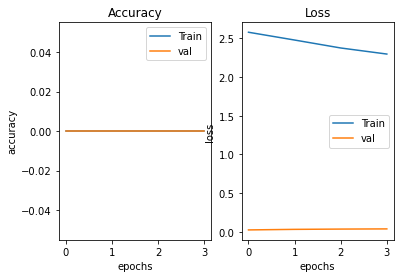

Train on 1805 samples, validate on 95 samples
Epoch 1/20
1805/1805 [==============================] - 61s 34ms/sample - loss: 2.5413 - accuracy: 9.2304e-09 - val_loss: 0.0332 - val_accuracy: 0.0000e+00
Epoch 2/20
1805/1805 [==============================] - 60s 33ms/sample - loss: 2.3713 - accuracy: 9.2304e-09 - val_loss: 0.0452 - val_accuracy: 0.0000e+00
Epoch 3/20
1805/1805 [==============================] - 60s 33ms/sample - loss: 2.2820 - accuracy: 9.2304e-09 - val_loss: 0.0542 - val_accuracy: 0.0000e+00
Epoch 4/20
1805/1805 [==============================] - 60s 33ms/sample - loss: 2.1673 - accuracy: 9.2304e-09 - val_loss: 0.0614 - val_accuracy: 0.0000e+00


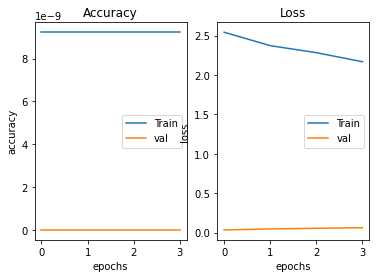

Train on 1805 samples, validate on 95 samples
Epoch 1/20
1805/1805 [==============================] - 257s 142ms/sample - loss: 2.4766 - accuracy: 9.2304e-09 - val_loss: 0.0385 - val_accuracy: 0.0000e+00
Epoch 2/20
1805/1805 [==============================] - 130s 72ms/sample - loss: 2.2661 - accuracy: 1.8461e-08 - val_loss: 0.0517 - val_accuracy: 0.0000e+00
Epoch 3/20
1805/1805 [==============================] - 123s 68ms/sample - loss: 2.0888 - accuracy: 9.2304e-09 - val_loss: 0.0550 - val_accuracy: 0.0000e+00
Epoch 4/20
1805/1805 [==============================] - 125s 69ms/sample - loss: 1.8880 - accuracy: 9.2304e-09 - val_loss: 0.0580 - val_accuracy: 0.0000e+00


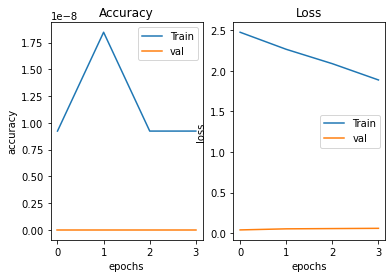

In [7]:
pm = [1024,2048,4096]
aex = {}
hist = {}

for i in range(3):
    aex[i] = ae(
        input_dim = X_train_ae.shape[1],
        encode_dim = pm[i]
        )

    hist[i] = aex[i].fit(
        X_train_ae,X_train_ae,
        epochs = 20,
        batch_size = batch_size,
        callbacks = [cb_es],
        validation_split = 0.05,
        shuffle = True
        )
    
    vis_learn(hist[i])

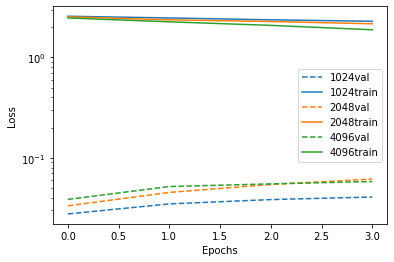

In [9]:
def plot_hist(histories,key = 'loss'):

    for name,history in histories:
        val = plt.plot(
            history.epoch,history.history['val_'+key],
            '--',label = name.title() + 'val'
            )
        plt.plot(history.epoch,history.history[key],color = val[0].get_color(),
        label = name.title() + 'train'
        )

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.legend()

plot_hist(
    [
        ('1024',hist[0]),
        ('2048',hist[1]),
        ('4096',hist[2])
    ]


)

TrainよりもValのほうがLossが低く出ている→学習できていない ただし中間層が多いほうが、学習しようとはしている

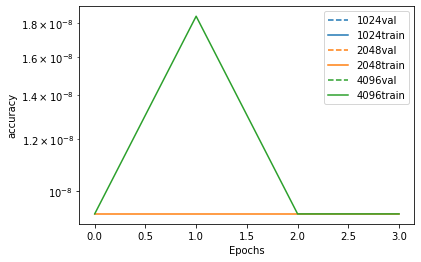

In [10]:
def plot_hist(histories,key = 'accuracy'):

    for name,history in histories:
        val = plt.plot(
            history.epoch,history.history['val_'+key],
            '--',label = name.title() + 'val'
            )
        plt.plot(history.epoch,history.history[key],color = val[0].get_color(),
        label = name.title() + 'train'
        )

    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.yscale("log")
    plt.legend()

plot_hist(
    [
        ('1024',hist[0]),
        ('2048',hist[1]),
        ('4096',hist[2])
    ]


)

中間層が大きいほうが何とかaccuracyを高めよう(≒学習しよう)としようとしているのは見て取れる しかし圧縮次元がPCAより高くとらなければならないというのは、PCAに対するメリットが何もないことを意味していないか？

## わかったこと
中間層を増やせばaccuracyは高まろうとする ただしそれはPCAに対する優位性がないことを意味する  
MINST等でうまくいくということは、スペクトログラムというデータの性質とAEの相性が良くないということか？

## 次にやること
いよいよAEを使う優位性がなくなってきたので、いったん`sklearn.decomposition.IncrimentalPCA`中心での開発に移行する  
AEチューニングの優先度は下げる